## Formulação matemática do problema da Grade Horária na UFPR Campus Pontal (Timetabling)


### Objetivo

O objetivo desta modelagem é minimizar a quantidade de vezes que os professores da UFPR Campus Pontal vão ao campus.
Vamos levar em conta dados originais obtidos em contato com a universidade e restrições reais.


### Parâmetros

Para modelar, temos as variáveis: 

* **T**: conjunto de turmas (8 turmas em LCE)
* **P**: conjunto de professores (16 professores em LCE)
* **H**: conjunto de horários das aulas (1 ou 2 - primeiro ou segundo horário)
* **D**: conjunto de dias da semana que ocorrem aulas (varia de segunda a sexta)

Total de combinações: $8 * 16 * 2 * 5 = 1280$.


### Variáveis de Decisão

As variáveis $x_{p,t,d,h}$ são inteiras e binárias, que definem se o professor $p$ irá (1) ou não (0) ministrar aula para a turma $t \in T$ no dia $d \in D$ e no horário $h \in H$.


### Problema de Otimização

$$
\begin{align}
    \text{minimizar \ \ \ \ \ } & \sum_{d=1}^{5}x_{p,t,d,h} \\
    \text{sujeito a \ \ \ \ \ } & \sum_{p=1}^{16}x_{p,t,d,h} \leq 1 \\
                                & \sum_{t=1}^{8}x_{p,t,d,h} \leq 1 \\
                                & \sum_{p=1}^{16}\sum_{h=1}^{2}x_{p,t,d,h} = HT_{t,d} \\
                                & \sum_{d=1}^{5}\sum_{h=1}^{2}x_{p,t,d,h} = R_{p,t} \\
                                & \sum_{t \in T_1}\sum_{p \in P_1}x_{p,t,d,h} = 2 \\
                                & \sum_{h=1}^{}x_{ptdh} \leq 6
\end{align}
$$

onde:

- $H$:
- $T_{t,d}$:
- $R_{p,t}$:
- $T_1$: subconjunto das turmas $T$ com aulas comuns às três habilitações
- $P_1$: subconjunto dos professores $P$ que ministram aulas nas disciplinas comuns

### Explicação das Restrições

1. Cada combinação de turma, horário e dia da semana terá somente 1 professor alocado
2. Cada combinação de professor, horário e dia da semana terá somente 1 turma sendo ministrada
3. 
4.
5.

## v2
Nessa versão colocaremos outros cursos

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

In [138]:
def constroi_lista(df:pd.DataFrame, coluna:str):
    lista = list(df[df['Curso'].isin(['LCE', 'LCEFISICA', 'LCEMATEMATICA', 'LCEQUIMICA','EAQ'])][coluna].dropna().unique())
    return lista

# def constroi_lista(df:pd.DataFrame, coluna:str):
#     lista = list(df[df['Curso'].isin(['LCE'])][coluna].dropna().unique())
#     return lista

In [139]:
grade_compilada = pd.read_csv('dados/grade_compilada.csv', sep=';')
grade_compilada_tratado = pd.read_csv('dados/grade_compilada_tratado.csv', sep=',')
hora_aula_materia = pd.read_csv('dados/hora_aula_materia.csv', sep=',')
materias_comuns = pd.read_csv('dados/materias_comuns.csv', sep=',')
professores_materias = pd.read_csv('dados/professores_materias.csv', sep=',')

In [140]:
materias_comuns.tail()

,Professor,Campus,Materia,Semestre_Curso
7,ELIANE,MIRASOL,DIVULGACAOCIENTIFICACEM326,5_LCEMATEMATICA
8,VALDIR,MIRASOL,PRATICAPEDAGOGICADOENSINOCEM335,5_LCEQUIMICA
9,JEINNI,MIRASOL,DIDATICADASCIENCIASCEM334,5_LCEQUIMICA
10,JEINNI,MIRASOL,ESTAGIOCIENCIASICEM336,5_LCEQUIMICA
11,ELIANE,MIRASOL,DIVULGACAOCIENTIFICACEM326,5_LCEQUIMICA


In [141]:
professores_materias[professores_materias['Curso'].isin(['LCE'])].count()

Professor     14
Campus        14
Curso         14
Tipo_Curso    14
Materia       14
dtype: int64

## Modelagem


In [142]:
# altera o index do hora_aula_materia
df_hor = hora_aula_materia.set_index(['Professor','Semestre_Curso','Materia']) 
df_hor

Curso  \
Professor Semestre_Curso  Materia                                              
ALEX      1_EAS           CALCULODIFERENCIALEINTEGRALI                   EAS   
          1_ECV           CALCULOI                                       ECV   
          5_LCEMATEMATICA GEOMETRIAECONSTRUCOESCEM319          LCEMATEMATICA   
ARMANI    1_EAS           INTRODUCAOAENGENHARIAAMBIENTAL                 EAS   
          7_EAS           POLUICAODOAR                                   EAS   
...                                                                      ...   
VALDIR    5_LCEMATEMATICA PRATICAPEDAGOGICADOENSINOCEM335      LCEMATEMATICA   
          5_LCEQUIMICA    PRATICAPEDAGOGICADOENSINOCEM335         LCEQUIMICA   
          7_LCEMATEMATICA PRATICAPEDAGOGICAMATEMATICAIICEM339  LCEMATEMATICA   
VIRNEI    3_EAQ           FISICAGERAL                                    EAQ   
          3_EAS           FISICAII                                       EAS   

                                                               Total_Horas  \
Professor Semestre_Curso  Materia                                            
ALEX      1_EAS           CALCULODIFERENCIALEINTEGRALI                   4   
          1_ECV           CALCULOI                                       4   
          5_LCEMATEMATICA GEOMETRIAECONSTRUCOESCEM319                    4   
ARMANI    1_EAS           INTRODUCAOAENGENHARIAAMBIENTAL                 4   
          7_EAS           POLUICAODOAR                                   3   
...                                                                    ...   
VALDIR    5_LCEMATEMATICA PRATICAPEDAGOGICADOENSINOCEM335                2   
          5_LCEQUIMICA    PRATICAPEDAGOGICADOENSINOCEM335                2   
          7_LCEMATEMATICA PRATICAPEDAGOGICAMATEMATICAIICEM339            4   
VIRNEI    3_EAQ           FISICAGERAL                                    4   
          3_EAS           FISICAII                                       3   

                                                               Periodos_Total  
Professor Semestre_Curso  Materia                                              
ALEX      1_EAS           CALCULODIFERENCIALEINTEGRALI                    2.0  
          1_ECV           CALCULOI                                        2.0  
          5_LCEMATEMATICA GEOMETRIAECONSTRUCOESCEM319                     2.0  
ARMANI    1_EAS           INTRODUCAOAENGENHARIAAMBIENTAL                  2.0  
          7_EAS           POLUICAODOAR                                    2.0  
...                                                                       ...  
VALDIR    5_LCEMATEMATICA PRATICAPEDAGOGICADOENSINOCEM335                 1.0  
          5_LCEQUIMICA    PRATICAPEDAGOGICADOENSINOCEM335                 1.0  
          7_LCEMATEMATICA PRATICAPEDAGOGICAMATEMATICAIICEM339             2.0  
VIRNEI    3_EAQ           FISICAGERAL                                     2.0  
          3_EAS           FISICAII                                        2.0  

[193 rows x 3 columns]

In [143]:
hora_aula_materia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Professor       193 non-null    object 
 1   Materia         193 non-null    object 
 2   Semestre_Curso  193 non-null    object 
 3   Curso           193 non-null    object 
 4   Total_Horas     193 non-null    int64  
 5   Periodos_Total  193 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 9.2+ KB


In [144]:
def get_hora_aula_materia(professor,materia, turma, df=df_hor):
    resultado = hora_aula_materia.query("Semestre_Curso == @turma and Materia == @materia and Professor == @professor")
    if not resultado.empty:
        return float(resultado['Total_Horas'].iloc[0])
    else:
        return 0

In [145]:
get_hora_aula_materia('ALEX','CALCULODIFERENCIALEINTEGRALI', '1_EAS')

4.0

In [146]:
# def get_hora_aula_prof(professor, turma, df=df_hor):
#     resultado = hora_aula_materia.query("Semestre_Curso == @turma and Professor == @professor")
#     if not resultado.empty:
#         return float(resultado['Periodos_Total'].sum())
#     else:
#         return 0
# get_hora_aula_materia('BELZ','7_EAQ')

In [147]:
df_turno = grade_compilada_tratado[['Tipo_Curso','Semestre_Curso']].set_index(['Semestre_Curso'])

In [148]:
def get_turno(turma, df=df_turno):
    resultado = df.query("Semestre_Curso == @turma")
    if not resultado.empty:
        return resultado['Tipo_Curso'].iloc[0]
    else:
        return 0

In [149]:
get_turno("1_EAQ")

'MATUTINO'

### Parâmetros

In [150]:
# Define os conjuntos
professores = constroi_lista(df = grade_compilada_tratado, coluna = 'Professor') 
turmas = constroi_lista(df = grade_compilada_tratado, coluna = 'Semestre_Curso')
# turno = constroi_lista(df = grade_compilada_tratado, coluna='Tipo_Curso') #Matutino/Noturno
dias_semana = constroi_lista(df = grade_compilada_tratado, coluna = 'Dia') # range(1, 6)
horarios = range(1, 14) 
disciplinas = constroi_lista(df = grade_compilada_tratado, coluna = 'Materia') 

professores_comuns = materias_comuns['Professor'].unique().tolist()
turmas_comuns = materias_comuns['Semestre_Curso'].unique().tolist()
disciplinas_comuns = materias_comuns['Materia'].unique().tolist()

In [151]:
# Define os turnos
turno_horarios = {
    'MATUTINO': [1,2,3,4],  # Horários no turno matutino
    'VESPERTINO':[5,6,7,8,9],
    'NOTURNO': [10,11,12,13],  # Horários no turno noturno
    'INTEGRAL': [1, 2,3,4,5,6,7,8,9]  # Horários permitidos para cursos integrais
}


# Atualiza o mapeamento de turmas para seus turnos usando a função `get_turno`
mapa_turma_turno = {}
for turma in turmas:
    turno = get_turno(turma)  # Determina o turno da turma
    if turno in turno_horarios:
        mapa_turma_turno[turma] = turno_horarios[turno]
    else:
        raise ValueError(f"Turno desconhecido para a turma: {turma}")

In [152]:
mapa_turma_turno

{'1_EAQ': [1, 2, 3, 4],
 '3_EAQ': [1, 2, 3, 4],
 '5_EAQ': [1, 2, 3, 4],
 '7_EAQ': [1, 2, 3, 4],
 '9_EAQ': [1, 2, 3, 4],
 '1_LCE': [10, 11, 12, 13],
 '3_LCE': [10, 11, 12, 13],
 '5_LCEFISICA': [10, 11, 12, 13],
 '5_LCEMATEMATICA': [10, 11, 12, 13],
 '5_LCEQUIMICA': [10, 11, 12, 13],
 '7_LCEFISICA': [10, 11, 12, 13],
 '7_LCEMATEMATICA': [10, 11, 12, 13],
 '7_LCEQUIMICA': [10, 11, 12, 13]}

In [191]:
# Inicialização do modelo
model = gp.Model("Alocação_Professores")


# tipo_curso_comum = ['MATUTINO']

# Cria as variáveis de decisão
x = model.addVars(professores, disciplinas,turmas, dias_semana, horarios, vtype=GRB.BINARY, name="x")
# Essa variável serve como indicador binário para saber se a disciplina mm está sendo ministrada pelo professor pp no dia dd e horário hh.
y = model.addVars(professores,disciplinas,dias_semana,horarios,vtype=GRB.BINARY, name="y")

#variáveis auxiliares
r2 = model.addVars(professores,dias_semana,horarios, vtype=GRB.BINARY, name="r2") # colocar na FO
r3 = model.addVars(turmas,dias_semana,horarios,vtype=GRB.BINARY, name="r3") # colocar na FO
# r5 = model.addVars(tipo_curso,turmas,dias_semana,horarios,vtype=GRB.BINARY, name="r5") # colocar na FO
r6 = model.addVars(professores,disciplinas,dias_semana,horarios,vtype=GRB.BINARY, name="r6") # colocar na FO
r7 = model.addVars(horarios,dias_semana, vtype=GRB.BINARY, name="r7") # colocar na FO
r8 = model.addVars(turmas,disciplinas,dias_semana, vtype=GRB.BINARY, name="r8") # colocar na FO
# # Define a função objetivo
# model.setObjective(gp.quicksum(x[c,p,m,t,d,h] 
#                                for c in tipo_curso
#                                for p in professores 
#                                for m in disciplinas 
#                                for t in turmas 
#                                for d in dias_semana 
#                                for h in horarios), GRB.MINIMIZE)
model.setObjective(gp.quicksum(r2[p,d,h]                                
                               for p in professores
                               for d in dias_semana 
                               for h in horarios
                               )+
                   gp.quicksum(r3[t,d,h]                                                           
                               for t in turmas 
                               for d in dias_semana 
                               for h in horarios)+                  
                   gp.quicksum(r7[h,d]                                                           
                               for d in dias_semana 
                               for h in horarios)+
                   gp.quicksum(r8[t,m,d]
                               for m in disciplinas 
                               for t in turmas 
                               for d in dias_semana)+
                   gp.quicksum(r6[p,m,d,h]
                               for m in disciplinas 
                               for p in professores
                               for d in dias_semana 
                               for h in horarios
                               )+
                   gp.quicksum(x[p,m,t,d,h]                                
                               for p in professores 
                               for m in disciplinas 
                               for t in turmas 
                               for d in dias_semana 
                               for h in horarios), GRB.MINIMIZE)
# Restrição 2 - Cada professor tem no máximo uma aula em um horário específico
for p in professores:
    for d in dias_semana:
        for h in horarios:
            model.addConstr(gp.quicksum(x[p,m,t,d,h]                                         
                                        for m in disciplinas 
                                        for t in turmas 
                                        if m not in disciplinas_comuns) <= 1 + 999*r2[p,d,h] , name=f'R2_{p}_{d}_{h}') # precisei adicionar o if para não dar conflito com 6

# Restrição 3 - Cada turma tem no máximo um professor em um horário específico

for t in turmas:
    for d in dias_semana:
        for h in horarios:
            model.addConstr(gp.quicksum(x[p,m,t,d,h] 
                                        for p in professores 
                                        for m in disciplinas 
                                        if m not in disciplinas_comuns) <= 1+999*r3[t,d,h] , name=f'R3_{t}_{d}_{h}') # precisei adicionar o if para não dar conflito com 6

# Restrição 5 
# "associa cada disciplina ao professora que ira lecionar cada uma delas e quantos periodos deve aparecer"
for p in professores:
    for t in turmas:
        for m in disciplinas:
            model.addConstr(gp.quicksum(x[p,m,t,d,h] for d in dias_semana for h in horarios) == get_hora_aula_materia(p,m,t), name=f'R5_{p}_{m}_{t}') # R_p,t

# Restrição 6 # Conflito com essa tbm
# # T1 ⊂ T (subconj. das turmas com aulas comuns) e P1 ⊂ P (subconj. dos professores das aulas comuns)
# for p in professores_comuns:
#     for m in disciplinas_comuns:        
#         for d in dias_semana:
#             for h in horarios:
#                 model.addConstr(gp.quicksum(x[p,m,t,d,h] for t in turmas_comuns) <= 3 +999*r6[p,m,d,h] , name=f'R6_{p}_{m}_{d}_{h}') 

for p in professores_comuns:
    for m in disciplinas_comuns:
        for d in dias_semana:
            for h in horarios:
                # Garante que se uma disciplina comum está alocada, ocorre simultaneamente para todas as turmas
                model.addConstr(
                    gp.quicksum(x[p, m, t, d, h] for t in turmas_comuns) ==
                    len(turmas_comuns) * y[p, m, d, h],
                    name=f'R6_{p}_{m}_{d}_{h}'
                )

# Restrição 7
# Garante que as aulas sejam alocadas nas 6 salas de aulas disponíveis do campus mirassol
# Isto é, a quantidade de aulas a cada horário deve ser no máximo 6, pois esse é o limite de salas
for h in horarios:
    for d in dias_semana:    
        model.addConstr(gp.quicksum(x[p,m,t,d,h]
                                    for p in professores 
                                    for m in disciplinas
                                    for t in turmas
                                   ) <= 6 + 9999*r7[h,d]  , name=f'R7_{d}_{h}')
        
# Restrição para garantir que disciplinas sejam alocadas apenas nos horários permitidos do turno da turma
for t in turmas:
    horarios_permitidos = mapa_turma_turno[t]  # Horários válidos com base no turno
    for m in disciplinas:
        for d in dias_semana:
            model.addConstr(
                gp.quicksum(x[p, m, t, d, h] for p in professores for h in horarios if h not in horarios_permitidos) <= 0 + 9999*r8[t,m,d],
#                 gp.quicksum(x[p, m, t, d, h] for p in professores for h in horarios),
                name=f'R8_{t}_{m}_{d}'
            )
model.write('modelo_v2.lp')


In [192]:
# Resolve o modelo
model.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22621.2))

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 35334 rows, 2062450 columns and 8138650 nonzeros
Model fingerprint: 0x499ba2ee
Variable types: 0 continuous, 2062450 integer (2062450 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 347.0000000
Presolve removed 32963 rows and 2056055 columns
Presolve time: 2.33s
Presolved: 2371 rows, 6395 columns, 20705 nonzeros
Variable types: 0 continuous, 6395 integer (6395 binary)

Root relaxation: objective 2.040000e+02, 1498 iterations, 0.04 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incum

In [193]:
model.write('solucao.sol')

In [194]:
materias_comuns.tail()

,Professor,Campus,Materia,Semestre_Curso
7,ELIANE,MIRASOL,DIVULGACAOCIENTIFICACEM326,5_LCEMATEMATICA
8,VALDIR,MIRASOL,PRATICAPEDAGOGICADOENSINOCEM335,5_LCEQUIMICA
9,JEINNI,MIRASOL,DIDATICADASCIENCIASCEM334,5_LCEQUIMICA
10,JEINNI,MIRASOL,ESTAGIOCIENCIASICEM336,5_LCEQUIMICA
11,ELIANE,MIRASOL,DIVULGACAOCIENTIFICACEM326,5_LCEQUIMICA


In [199]:
# Supondo que model.Status == GRB.OPTIMAL e x tenha os resultados
dados = []
for p,m, t, d, h in x:
    if x[ p,m, t, d, h].X > 0:
        dados.append({
            "Professor":p,
            "Turma": t,
            "Disciplina": m,            
            "Dia": d,
            "Periodo": h
        })

# Cria um DataFrame a partir dos dados
df_resultado = pd.DataFrame(dados)
# df_resultado = df_resultado.sort_values(by=["Turma", "Disciplina", "Dia", "Periodo"])


In [200]:
df_resultado[df_resultado['Disciplina'].isin(["DIVULGACAOCIENTIFICACEM326"])].sort_values('Dia')

,Professor,Turma,Disciplina,Dia,Periodo
120,ELIANE,5_LCEFISICA,DIVULGACAOCIENTIFICACEM326,TERCA,10
121,ELIANE,5_LCEFISICA,DIVULGACAOCIENTIFICACEM326,TERCA,11
122,ELIANE,5_LCEMATEMATICA,DIVULGACAOCIENTIFICACEM326,TERCA,10
123,ELIANE,5_LCEMATEMATICA,DIVULGACAOCIENTIFICACEM326,TERCA,11
124,ELIANE,5_LCEQUIMICA,DIVULGACAOCIENTIFICACEM326,TERCA,10
125,ELIANE,5_LCEQUIMICA,DIVULGACAOCIENTIFICACEM326,TERCA,11


In [201]:
# Exibir as variáveis com valor igual a 1
for v in model.getVars():
   
    if v.X > 0.99:
        print(f'{v.VarName}: {v.X}')

x[LAGREZE,INTRODUCAOAAQUICULTURA,1_EAQ,QUINTA,4]: 1.0
x[LAGREZE,INTRODUCAOAAQUICULTURA,1_EAQ,SEXTA,1]: 1.0
x[LAGREZE,MALACOCULTURA,7_EAQ,TERCA,3]: 1.0
x[LAGREZE,MALACOCULTURA,7_EAQ,SEXTA,2]: 1.0
x[LAGREZE,ELABORACAODEPROJETOS,9_EAQ,QUINTA,1]: 1.0
x[LAGREZE,ELABORACAODEPROJETOS,9_EAQ,QUINTA,3]: 1.0
x[LAGREZE,HIDRAULICAAQUICULTURA,9_EAQ,SEGUNDA,2]: 1.0
x[LAGREZE,HIDRAULICAAQUICULTURA,9_EAQ,SEGUNDA,3]: 1.0
x[LAGREZE,HIDRAULICAAQUICULTURA,9_EAQ,SEGUNDA,4]: 1.0
x[LAGREZE,HIDRAULICAAQUICULTURA,9_EAQ,QUARTA,3]: 1.0
x[CENDON,PROBABILIDADE,1_EAQ,TERCA,4]: 1.0
x[CENDON,PROBABILIDADE,1_EAQ,QUINTA,1]: 1.0
x[SACHSIDA,INTRODUCAOAQUALIDADE,1_EAQ,QUARTA,1]: 1.0
x[SACHSIDA,INTRODUCAOAQUALIDADE,1_EAQ,QUINTA,3]: 1.0
x[SACHSIDA,NUTRICAO,3_EAQ,SEGUNDA,1]: 1.0
x[SACHSIDA,NUTRICAO,3_EAQ,SEGUNDA,2]: 1.0
x[SACHSIDA,NUTRICAO,3_EAQ,SEGUNDA,3]: 1.0
x[SACHSIDA,NUTRICAO,3_EAQ,QUINTA,2]: 1.0
x[LUCIANA,GEOMETRIAANALITICA,1_EAQ,QUINTA,2]: 1.0
x[LUCIANA,GEOMETRIAANALITICA,1_EAQ,SEXTA,3]: 1.0
x[LUCIANA,MATEMATICAELEMENT

x[ALEX,GEOMETRIAECONSTRUCOESCEM319,5_LCEMATEMATICA,TERCA,12]: 1.0
x[ALEX,GEOMETRIAECONSTRUCOESCEM319,5_LCEMATEMATICA,QUARTA,12]: 1.0
x[ALEX,GEOMETRIAECONSTRUCOESCEM319,5_LCEMATEMATICA,QUINTA,12]: 1.0
x[ALEX,GEOMETRIAECONSTRUCOESCEM319,5_LCEMATEMATICA,SEXTA,11]: 1.0
x[PEDRO,QUIMICAANALITICAICEM358,5_LCEQUIMICA,SEGUNDA,10]: 1.0
x[PEDRO,QUIMICAANALITICAICEM358,5_LCEQUIMICA,TERCA,11]: 1.0
x[PEDRO,QUIMICAANALITICAICEM358,5_LCEQUIMICA,QUARTA,13]: 1.0
x[PEDRO,QUIMICAANALITICAICEM358,5_LCEQUIMICA,SEXTA,13]: 1.0
x[CASSIO,FISICAMODERNAICEM352,7_LCEFISICA,SEGUNDA,12]: 1.0
x[CASSIO,FISICAMODERNAICEM352,7_LCEFISICA,TERCA,13]: 1.0
x[CASSIO,FISICAMODERNAICEM352,7_LCEFISICA,QUARTA,13]: 1.0
x[CASSIO,FISICAMODERNAICEM352,7_LCEFISICA,SEXTA,10]: 1.0
x[BORGES,TEORIADOSNUMEROSCEM322,7_LCEMATEMATICA,TERCA,13]: 1.0
x[BORGES,TEORIADOSNUMEROSCEM322,7_LCEMATEMATICA,QUARTA,13]: 1.0
x[BORGES,TEORIADOSNUMEROSCEM322,7_LCEMATEMATICA,SEXTA,11]: 1.0
x[BORGES,TEORIADOSNUMEROSCEM322,7_LCEMATEMATICA,SEXTA,13]: 1.0
x[BORGE

In [203]:
from collections import defaultdict

# Dicionário para agrupar variáveis pelo prefixo
resultados = defaultdict(list)

# Filtrar e agrupar variáveis com valor igual a 1 e que começam com 'r'
for v in model.getVars():
    if v.VarName.startswith('r') and v.X > 0.99:
        prefix = v.VarName.split('[')[0]  # Extrair o prefixo (ex: r2, r3, r5)
        resultados[prefix].append(v.VarName)

# Imprimir os resultados de forma organizada
for prefix, vars in resultados.items():
    print(f"\n{prefix}:")
    for var in vars:
        print(f"  {var}: 1.0")


C:\Users\talia\AppData\Local\Temp\ipykernel_17148\921958380.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  grade_horaria = df_turma.pivot('Dia', 'Periodo', 'Professor')


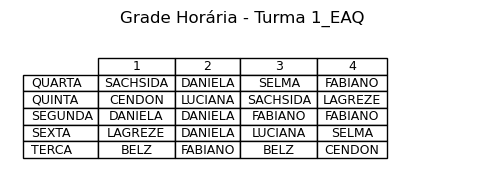

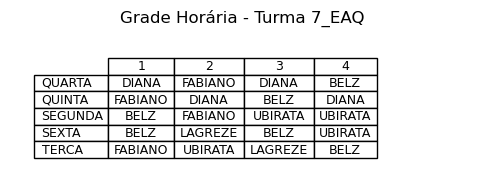

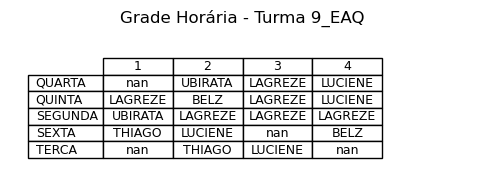

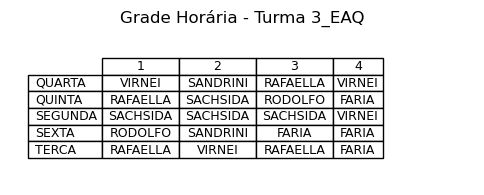

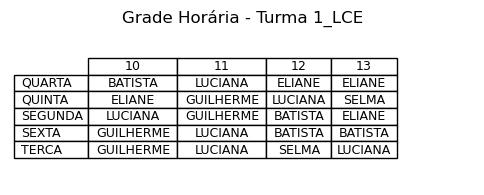

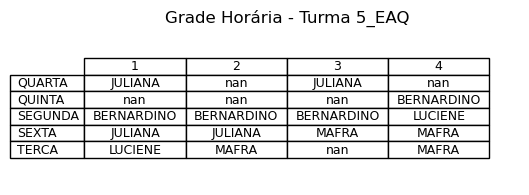

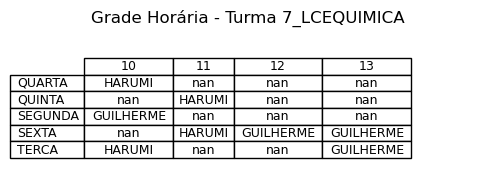

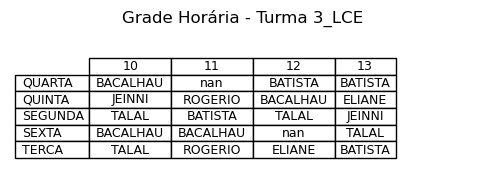

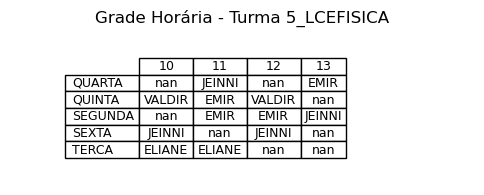

ValueError: Index contains duplicate entries, cannot reshape

In [204]:


# Função para criar a grade horária visualizada por turma
def plotar_grade_horaria(df):
    # Obter todas as turmas únicas
    turmas = df['Turma'].unique()
    
    for turma in turmas:
        # Filtrar o DataFrame para a turma atual
        df_turma = df[df['Turma'] == turma]

        # Criar um pivot table para visualização
        grade_horaria = df_turma.pivot('Dia', 'Periodo', 'Professor')

        # Plotar a grade horária manualmente
        fig, ax = plt.subplots(figsize=(6, 2))
        ax.axis('off')
        table = ax.table(cellText=grade_horaria.values,
                         rowLabels=grade_horaria.index,
                         colLabels=grade_horaria.columns,
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.auto_set_column_width(col=list(range(len(grade_horaria.columns))))
        plt.title(f'Grade Horária - Turma {turma}')
        plt.show()

# Chamar a função para plotar a grade horária
plotar_grade_horaria(df_resultado)


C:\Users\talia\AppData\Local\Temp\ipykernel_17148\2310566323.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  grade_horaria = df_professor.pivot('Dia', 'Periodo', 'Turma')


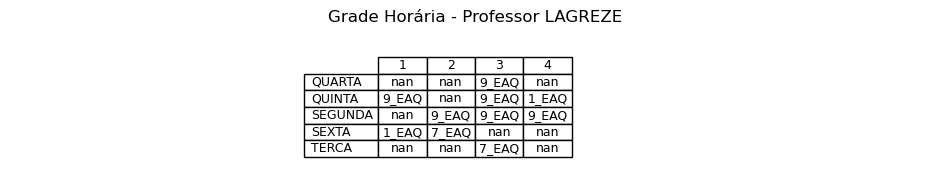

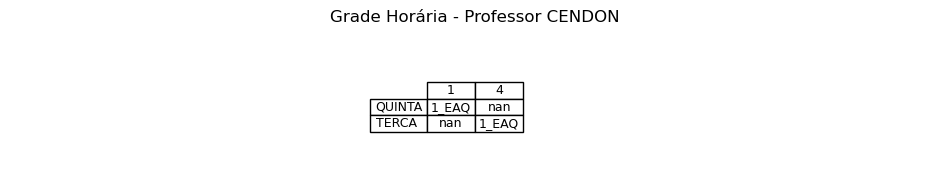

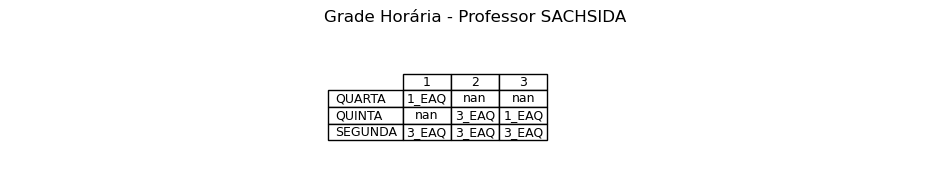

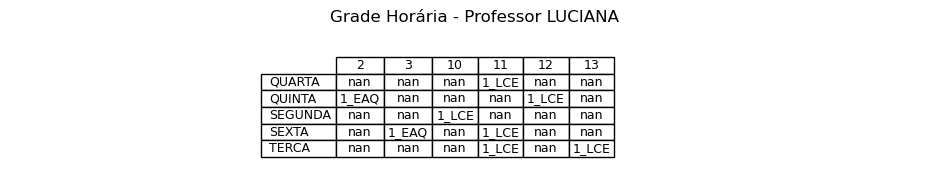

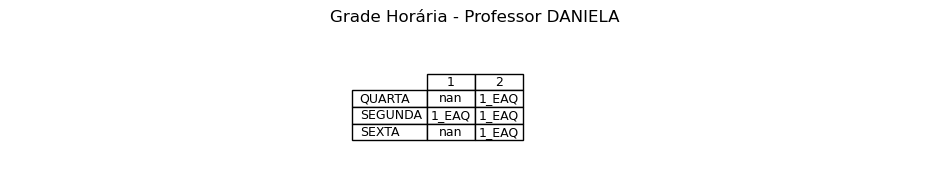

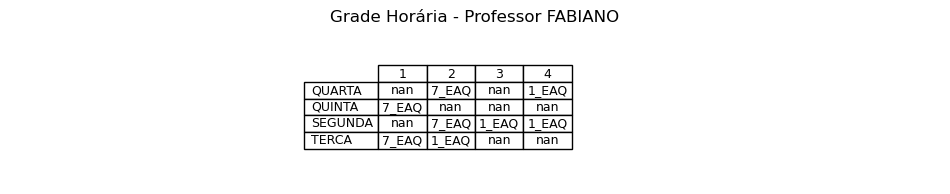

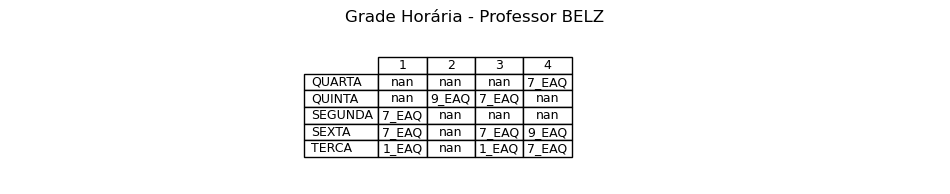

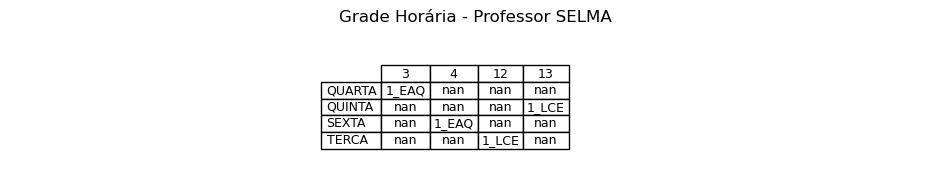

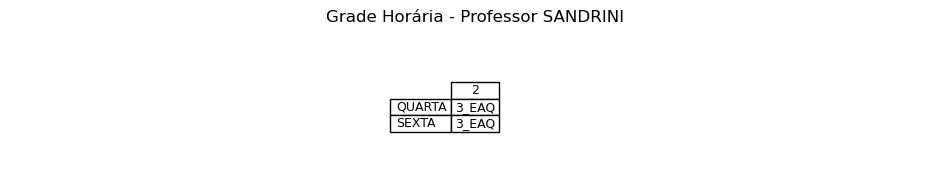

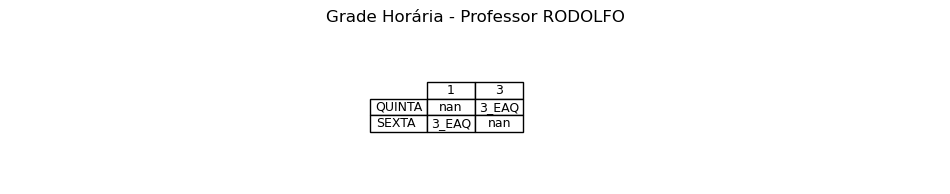

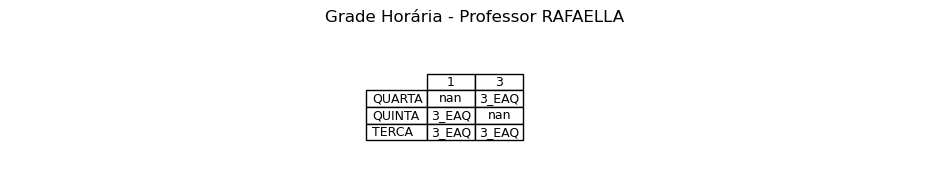

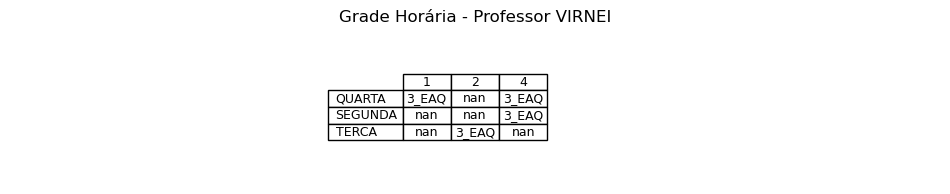

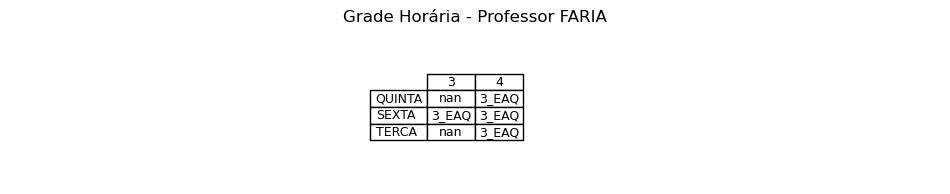

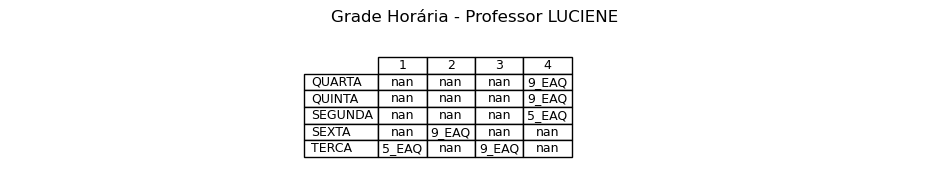

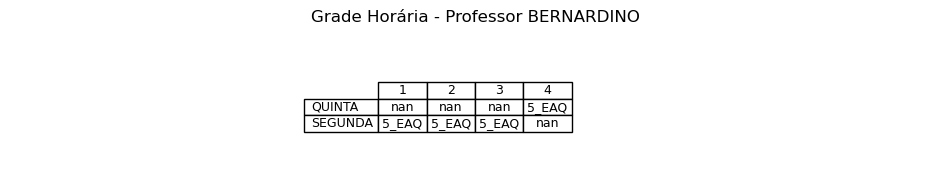

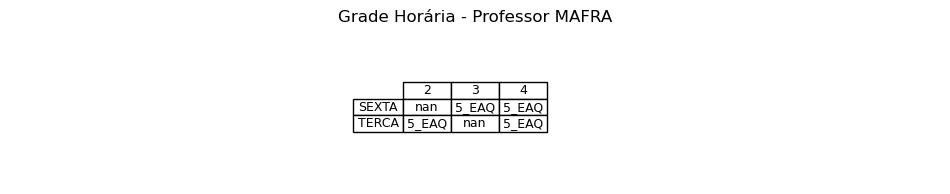

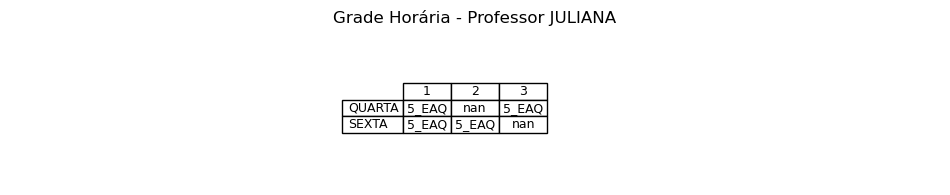

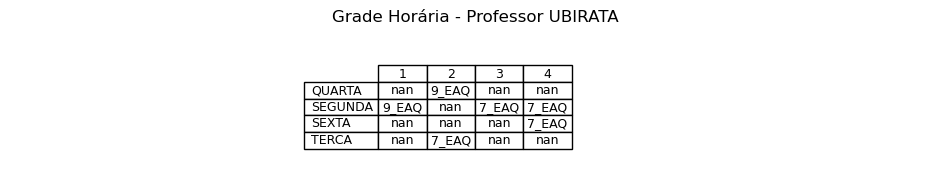

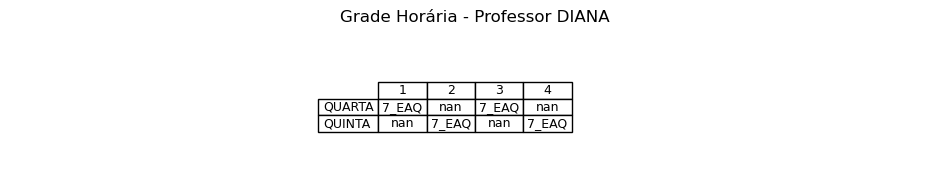

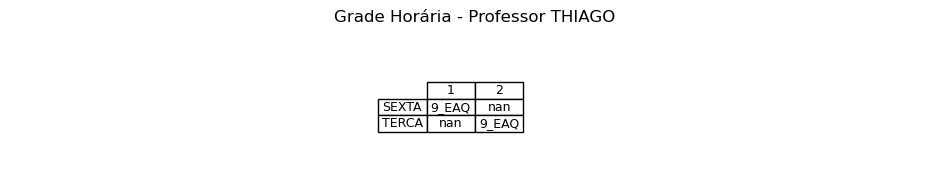

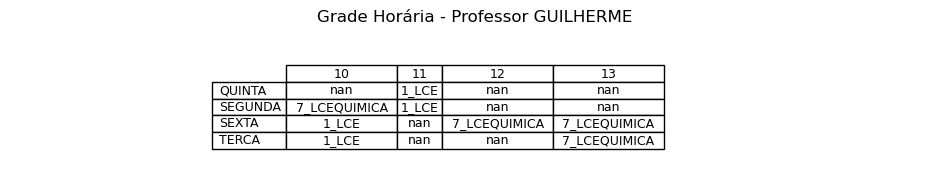

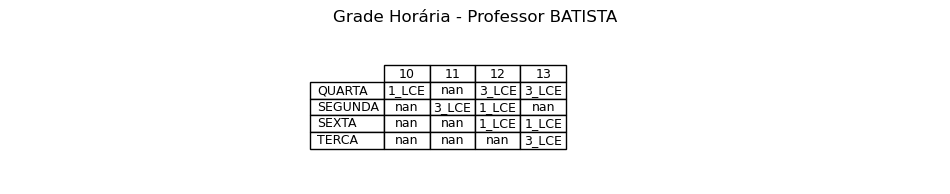

ValueError: Index contains duplicate entries, cannot reshape

In [205]:

# Função para criar a grade horária visualizada por professor
def plotar_grade_horaria_por_professor(df):
    # Obter todos os professores únicos
    professores = df['Professor'].unique()
    
    for professor in professores:
        # Filtrar o DataFrame para o professor atual
        df_professor = df[df['Professor'] == professor]

        # Criar um pivot table para visualização
        grade_horaria = df_professor.pivot('Dia', 'Periodo', 'Turma')

        # Plotar a grade horária manualmente
        fig, ax = plt.subplots(figsize=(12, 2))
        ax.axis('off')
        table = ax.table(cellText=grade_horaria.values,
                         rowLabels=grade_horaria.index,
                         colLabels=grade_horaria.columns,
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.auto_set_column_width(col=list(range(len(grade_horaria.columns))))
        plt.title(f'Grade Horária - Professor {professor}')
        plt.show()

# Chamar a função para plotar a grade horária
plotar_grade_horaria_por_professor(df_resultado)
